In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import os
import cftime

import sys
sys.path.append('../')
import utils
import main
import plot_utils

In [2]:
fold = '../../data/satellite/sst_subskin_l4/'
files = utils.dirtodict(fold)['.files']

ds = xr.open_mfdataset(files).convert_calendar('noleap').compute()

In [3]:
sst_max = ds.analysed_sst.resample(time='1D').max()
sst_min = ds.analysed_sst.resample(time='1D').min()
dif = sst_max - sst_min

It turns out that data for 17-05-2021 is corrupted. We replace the value for this day by the mean between the previous and next day. 

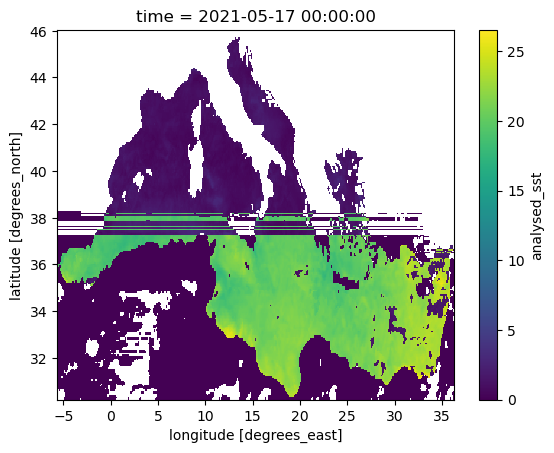

In [4]:
corrupted_date = cftime.DatetimeNoLeap(2021, 5, 17, 0, 0, 0, 0, has_year_zero=True)

#Plotting corrupted data
dif.sel(time = corrupted_date).plot()

#Replacing the data
replace = (dif.isel(time=365*2 + 135) + dif.isel(time=365*2 + 137))/2
dif = dif.where(dif.time != corrupted_date,replace)

In [5]:
seasonal_mean = dif.groupby('time.season').mean('time')

def get_quantile(da, q):
    value = main.run_avg_per(dif.quantile(q,['lat','lon']).groupby('time.dayofyear').mean('time'))
    return value

quantiles = [0.5, 0.25, 0.75, 0.05, 0.95]
median, p25, p75, p05, p95 = (get_quantile(dif, q) for q in quantiles)


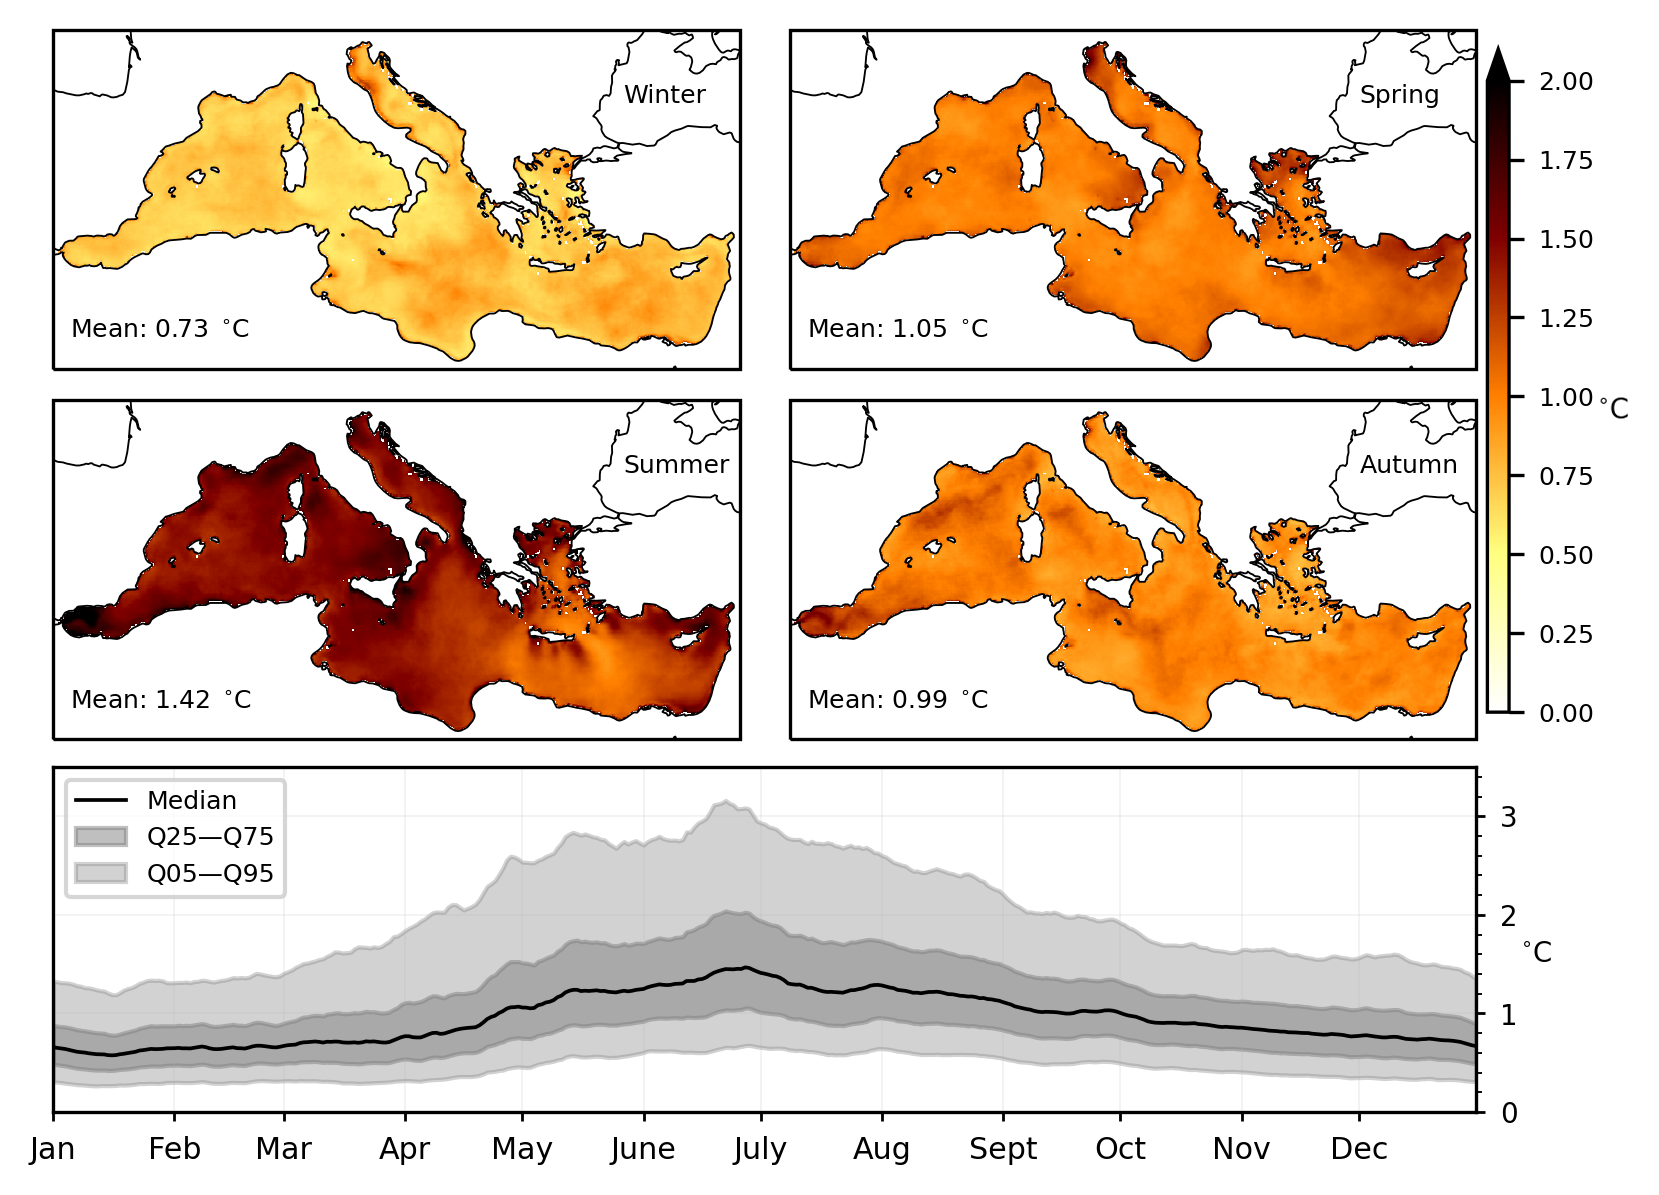

In [16]:
savefold = "../../figures/"
savepath = f"{savefold}/fig_S1.jpeg"

plot_utils.season_plot(seasonal_mean, median, ((p25, p75), (p05, p95)),
                        ratio=1.33, y_lim=[0,3.5], y_lim_map=[0,2],  y_label ='$^\circ$$\!$C',
                        cmap='afmhot_r', label_pos = 'upper left', savepath=savepath)